# Time series forecasting with sktime
Estimated time: 40 min

![](./img/tasks-forecasting.png)

## Agenda

- Quickstart
- Univariate forecasting
    - With statistical models
    - With machine learning models
    - Model evaluation and selection
- Univariate forecasting with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

## Quickstart

* typical business use case :-)
* here's some monthly historic sales data

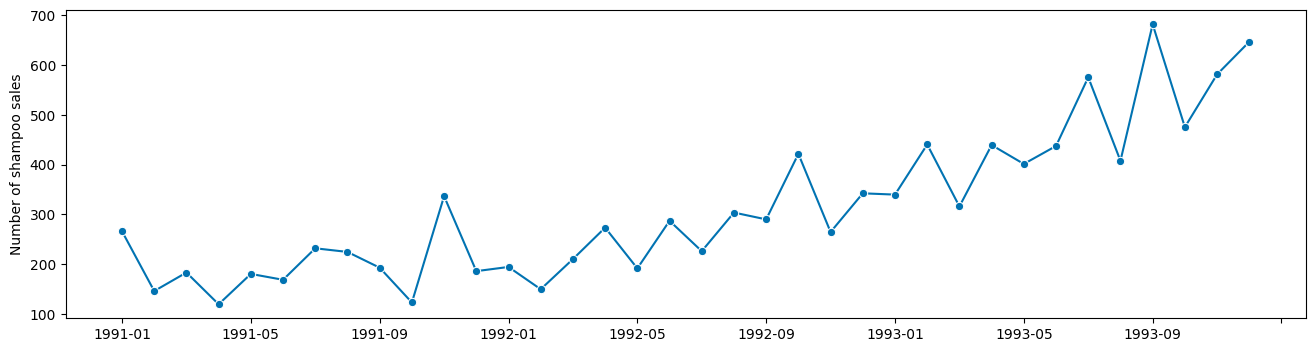

In [1]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

fig, ax = plot_series(y)

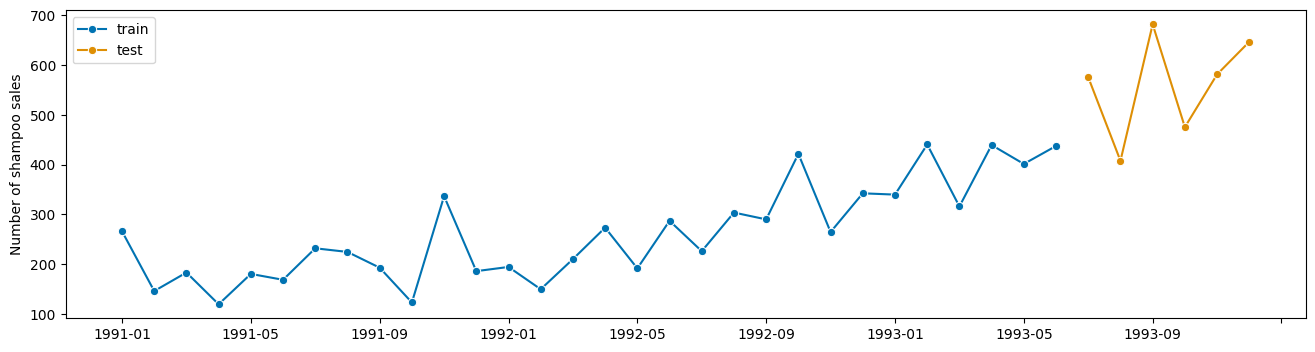

In [2]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y=y, test_size=6)
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

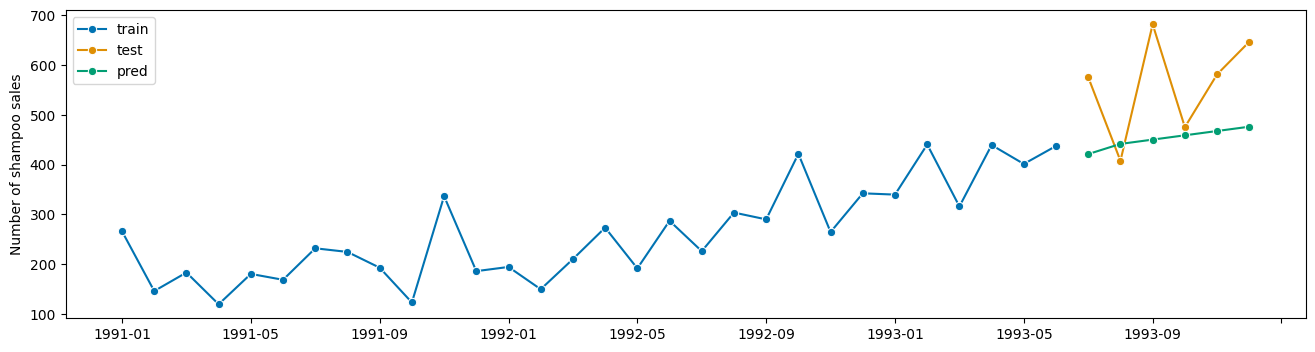

In [3]:
from sktime.forecasting.arima import AutoARIMA

# 1) Define the model
forecaster = AutoARIMA(suppress_warnings=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4, 5, 6] # Relative to y_train
y_pred = forecaster.predict(fh)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

* scoring using `sktime` performance metrics
* requires forecasts & true values as `sktime` compatible time series

In [4]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"AutoARIMA - sMAPE error: {smape(y_test, y_pred):.1%}")

AutoARIMA - sMAPE error: 22.6%


Notes:

* MAPE just for illustration - not always best choice
* for robust evaluation & comparison, use backtesting (not single train/test split)

## Univariate forecasting

showcase common approaches for forecasting univariate time series in `sktime`:
- Classical statistical models (e.g., econometric, ARIMA, etc)
- Machine learning models (e.g., direct/recursive reduction)

Recommendation: try simple models and naive baselines first!

### Classical forecasting method example: `AutoETS`

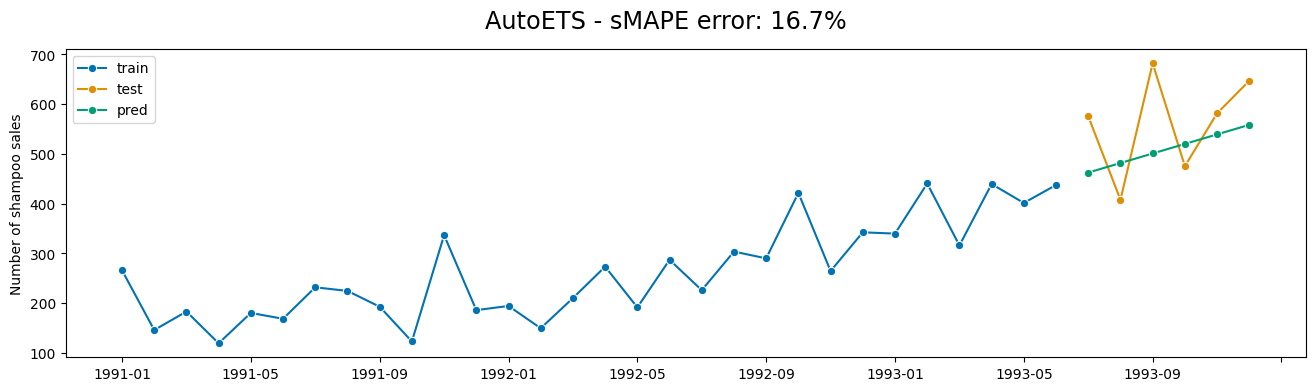

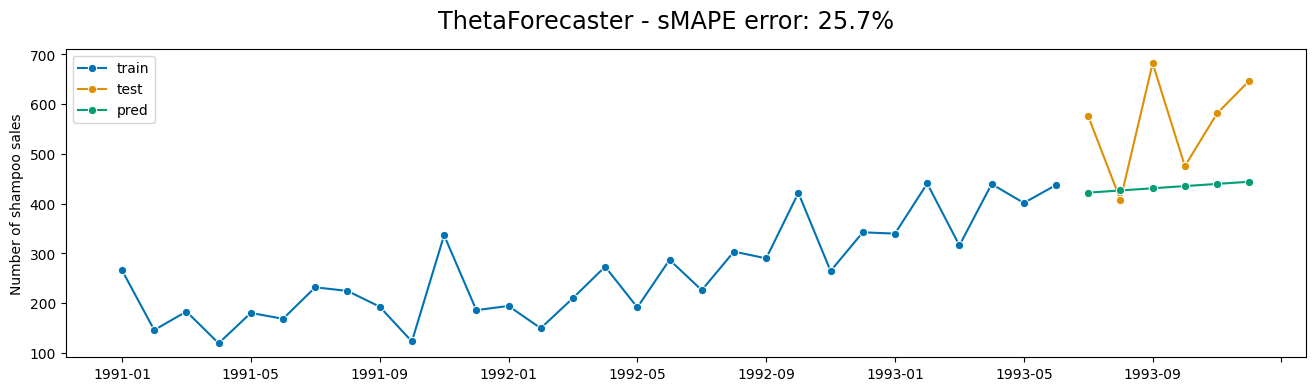

In [5]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.theta import ThetaForecaster

forecasters = [AutoETS(auto=True), ThetaForecaster()]

for forecaster in forecasters:
    y_pred = forecaster.fit_predict(y=y_train, fh=fh)
    title = (
        f"{str(forecaster).split('(')[0]} - sMAPE error: {smape(y_test, y_pred):.1%}"
    )
    fig, ax = plot_series(
        y_train, y_test, y_pred, labels=["train", "test", "pred"], title=title
    )

Check out all other sktime forecasting algorithms [in the documentation](https://www.sktime.net/en/latest/api_reference/forecasting.html) or by running the code below:

In [6]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True, suppress_import_stdout=False)

name                                             object
0                     ARDL             <class 'sktime.forecasting.ardl.ARDL'>
1                    ARIMA           <class 'sktime.forecasting.arima.ARIMA'>
2                AutoARIMA       <class 'sktime.forecasting.arima.AutoARIMA'>
3                  AutoETS           <class 'sktime.forecasting.ets.AutoETS'>
4   AutoEnsembleForecaster  <class 'sktime.forecasting.compose._ensemble.A...
..                     ...                                                ...
57       UpdateRefitsEvery  <class 'sktime.forecasting.stream._update.Upda...
58                     VAR               <class 'sktime.forecasting.var.VAR'>
59                  VARMAX         <class 'sktime.forecasting.varmax.VARMAX'>
60                    VECM             <class 'sktime.forecasting.vecm.VECM'>
61                  YfromX  <class 'sktime.forecasting.compose._reduce.Yfr...

[62 rows x 2 columns]

### Forecasting with ML algorithms (reduction)

- uses sklearn regressor on tabulated data to forecast
- plug & play any sklearn compatible regressor, e.g., lightgbm or xgboost
- important: forecasting != regression

Estimator does this internally:

![](../images/tabularization.png)

in unified forecasting interface! No need to handle `sklearn` directly

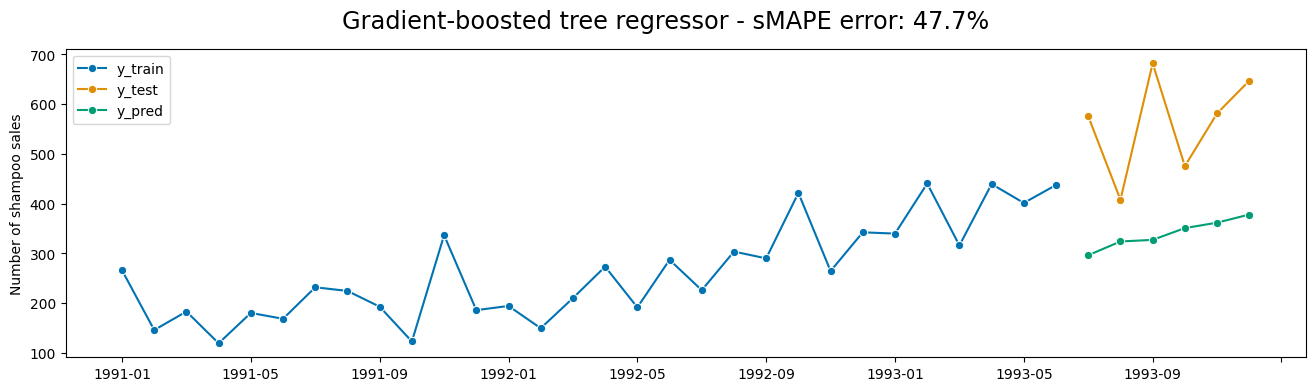

In [7]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

# Can be swapped with XBGoost, LightGBM, CatBoost, etc.
regressor = HistGradientBoostingRegressor()

# Create a forecaster from the tabular regressor by wrapping it in `make_reduction`
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

y_pred = forecaster.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

... this is bad! Why?

Subtle:

- Gradient boosting trees cannot "extrapolate"
- only forecast well within their observed range

Solution: make (more) stationary by differencing

easy to do in `sktime`: transformers (= transformation estimators)

(note: wider concept than deep learn transformers, includes simple trafos too)

Let's see how to use the `Differencer` transformer:

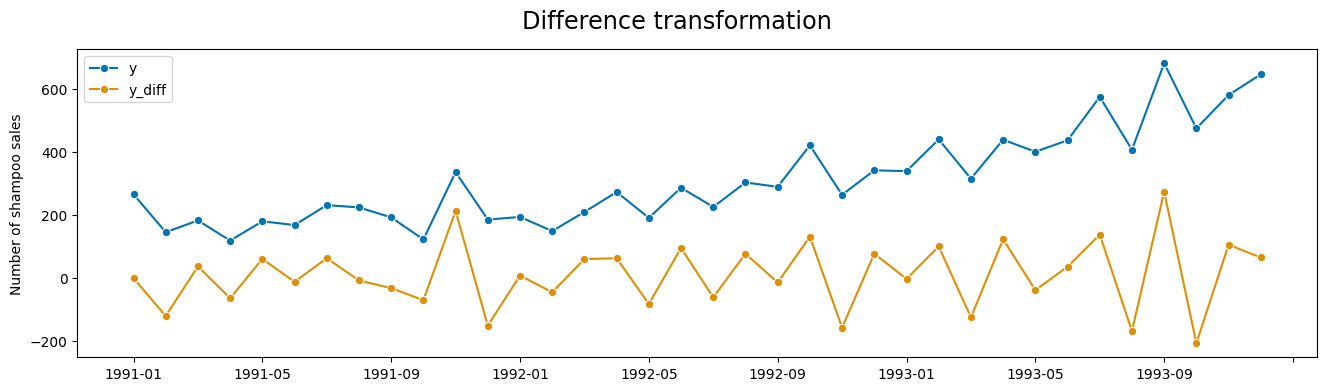

In [8]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
fig, ax = plot_series(
    y, y_transform, labels=["y", "y_diff"], title="Difference transformation"
)

Transformers composable with forecasters, plug together to forecaster!

here: plug `Differencer` into tree-based reduction forecaster, via `*` dunder:

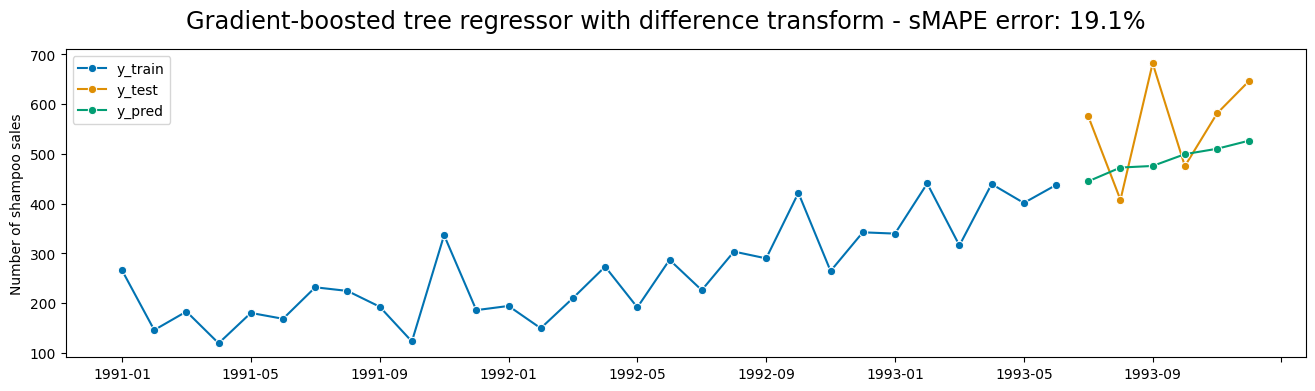

In [9]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)
forecaster_with_differencer = Differencer(lags=1) * forecaster

y_pred = forecaster_with_differencer.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor with difference transform - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

More on transformers and composition later!

### Model evaluation and selection

Best practice for model evaluation: backtesting, sliding window

(not single split MAPE etc...)

how this works:

* define backtesting schema using cross-validation splitter
* simple workflows: use `evaluate` all-in-one evaluator
* customizable: use benchmarking module for experiments

#### Window splitters

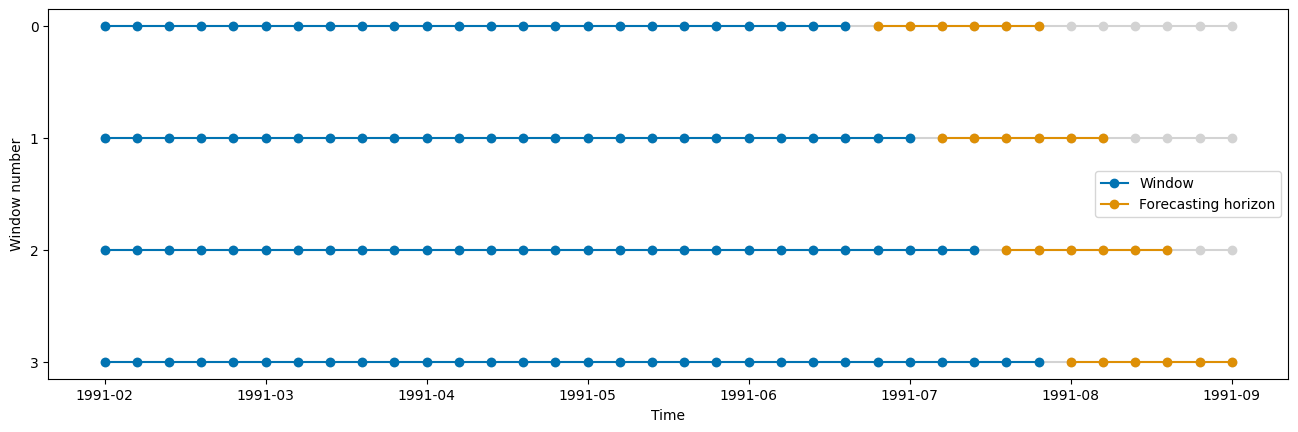

In [10]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

cv = ExpandingWindowSplitter(initial_window=24, fh=fh, step_length=2)
n_folds = cv.get_n_splits(y)
plot_windows(cv, y)

#### Backtesting for single model evaluation

We can leverage this more rebust cross-validation strategies for sinlge model evaluation by using `sktime`'s evaluat function.

In [11]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredError

forecaster = forecaster_with_differencer.clone()
scorers = [smape, MeanSquaredError(square_root=True)]
backtest = evaluate(
    forecaster=forecaster, y=y, cv=cv, scoring=scorers, return_data=True
)
backtest

test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                          0.073314  0.284485   0.039475                24   
1                          0.197408  0.379133   0.052433                26   
2                          0.157410  0.649803   0.053454                28   
3                          0.190791  0.661639   0.053474                30   

    cutoff                                            y_train  \
0  1992-12  1991-01    266.0
1991-02    145.9
1991-03    1...   
1  1993-02  1991-01    266.0
1991-02    145.9
1991-03    1...   
2  1993-04  1991-01    266.0
1991-02    145.9
1991-03    1...   
3  1993-06  1991-01    266.0
1991-02    145.9
1991-03    1...   

                                              y_test  \
0  1993-01    339.7
1993-02    440.4
1993-03    3...   
1  1993-03    315.9
1993-04    439.3
1993-05    4...   
2  1993-05    401.3
1993-06    437.4
1993-07    5...   
3  1993-07    575.5
1993-08    407.6
1993-09    6...   

                                              y_pred  test_MeanSquaredError  
0  1993-01    326.533333
1993-02    363.933333
19...              38.216397  
1  1993-03    443.72
1993-04    489.76
1993-05   ...              94.580702  
2  1993-05    438.042857
1993-06    459.600000
19...              97.546607  
3  1993-07    444.777778
1993-08    472.444444
19...             118.304354

In [12]:
backtest.loc[0, "y_pred"]

1993-01    326.533333
1993-02    363.933333
1993-03    364.900000
1993-04    430.100000
1993-05    417.066667
1993-06    434.533333
Freq: M, Name: Number of shampoo sales, dtype: float64

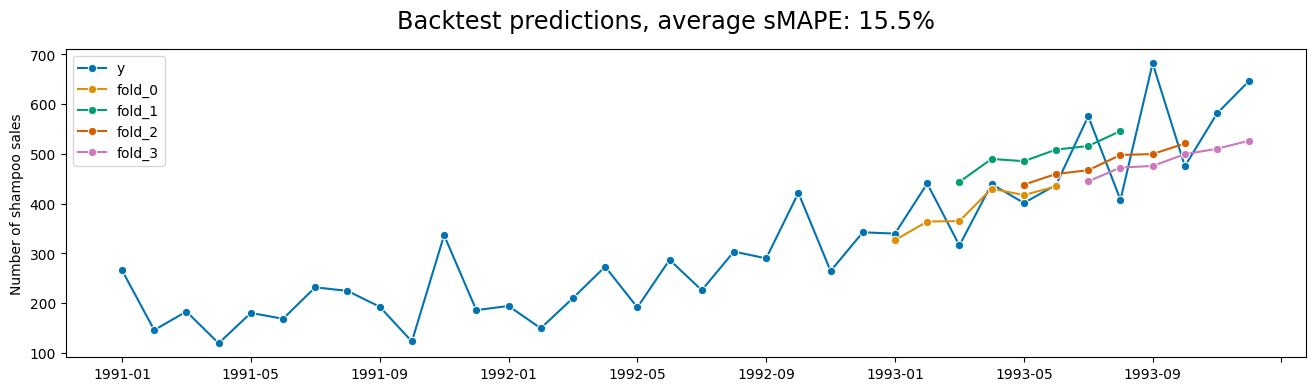

In [13]:
fig, ax = plot_series(
    y,
    *tuple(backtest["y_pred"][i] for i in range(n_folds)),
    labels=["y"] + [f"fold_{i}" for i in range(n_folds)],
    title=f"Backtest predictions, average sMAPE: {backtest['test_MeanAbsolutePercentageError'].mean():.1%}",
)

#### Advanced benchmarking via `ForecastingBenchmark`

* group of models in same benchmark scenario
* flexible set-up, e.g., splitters, evaluation metrics

Note: requires soft dependency [`kotsu`](https://github.com/datavaluepeople/kotsu) installed.

Start: create `ForecastingBenchmark` object

In [14]:
from sktime.benchmarking.forecasting import ForecastingBenchmark

benchmark = ForecastingBenchmark()

step 2: add models with `add_estimator` method.

Example: `NaiveForecaster` as simple benchmark model.

Good idea to assess baseline prediction accuracy!

In [15]:
from sktime.forecasting.naive import NaiveForecaster

benchmark.add_estimator(
    estimator=NaiveForecaster(strategy="mean", window_length=3),
    estimator_id="Naive-mean-3-v1",
)
benchmark.add_estimator(estimator=AutoARIMA(), estimator_id="AutoARIMA-v1")
benchmark.add_estimator(estimator=AutoETS(auto=True), estimator_id="AutoETS-v1")
benchmark.add_estimator(
    estimator=forecaster_with_differencer.clone(), estimator_id="LightGBM-v1"
)

Next - define backtest strategy `cv`, define forecasting tasks & scoring:

In [16]:
cv = ExpandingWindowSplitter(initial_window=24, fh=fh, step_length=2)
scorers = [smape]

benchmark.add_task(
    load_shampoo_sales,
    cv,
    scorers,
)

`run` to start benchmarking, this will now compute results:

In [17]:
results_df = benchmark.run(output_file="results.csv")
results_df.set_index("model_id").iloc[:, -2:].style.format("{:.1%}")

Currently in active development! (summer programme)

- Open to feedback
- Welcome and appreciate contributions

## Univariate forecasting with exogenous data

- exogeneous data = other related time series that can improve prediction
- Example: information about promotions when forecasting sales (promotions drive sales)


We start by loading the same sales data we have been working on before.

In [18]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()

Let's use the sales data, noise and some simple transformations to create *fake* promotion

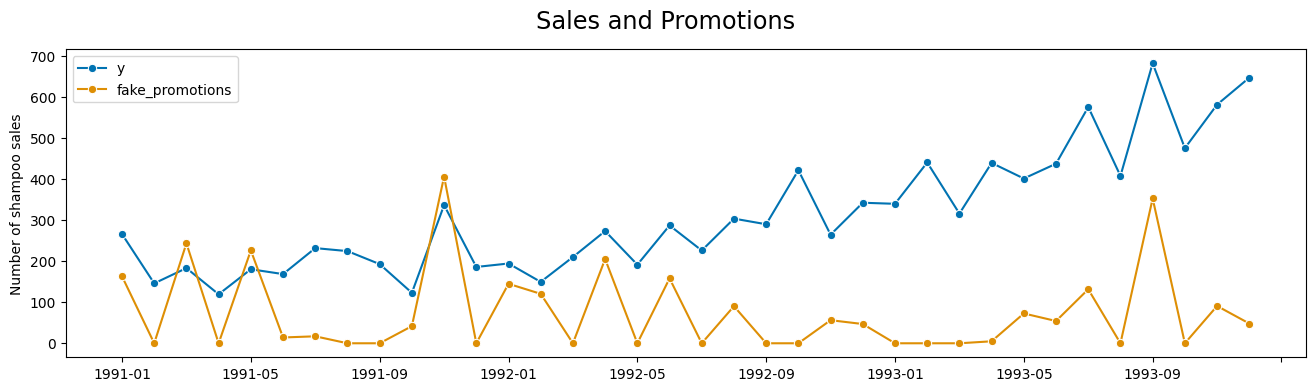

In [19]:
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer

# Use a differencer, clipping and some noise to generate fake promotional data
transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
noise = np.random.RandomState(seed=93).normal(0, 100, np.shape(y))
X_promo = (y_transform + noise).clip(lower=0)

fig, ax = plot_series(
    y, X_promo, labels=["y", "fake_promotions"], title="Sales and Promotions"
)

We can split both the target time series (y: sales) and the exogenous time series (X: promotions) with the `temporal_train_test_split` we have used before.

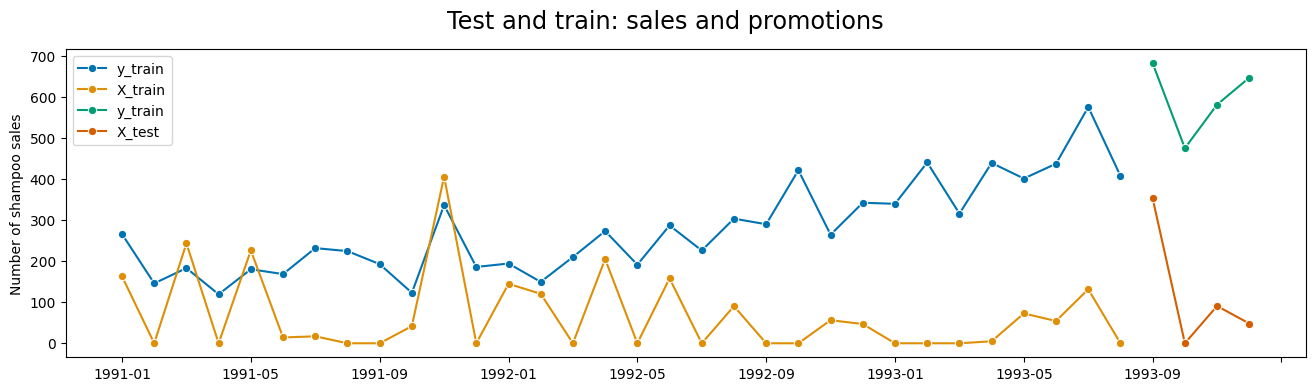

In [20]:
from sktime.forecasting.model_selection import temporal_train_test_split

fh = [1, 2, 3, 4]
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y=y, X=X_promo, test_size=len(fh)
)

fig, ax = plot_series(
    y_train,
    X_train,
    y_test,
    X_test,
    labels=["y_train", "X_train", "y_train", "X_test"],
    title="Test and train: sales and promotions",
)

Now we can forecast y (sales) also using the known values of future X (promotions) by passing the future X data in the predict step.

In [21]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(suppress_warnings=True)

# Use train data in fit
forecaster.fit(y=y_train, X=X_train, fh=fh)

# Note how the "future" data of X is passed in the predict step
y_pred = forecaster.predict(X=X_test)

Let's see how the prediction looks like when adding promotional data.

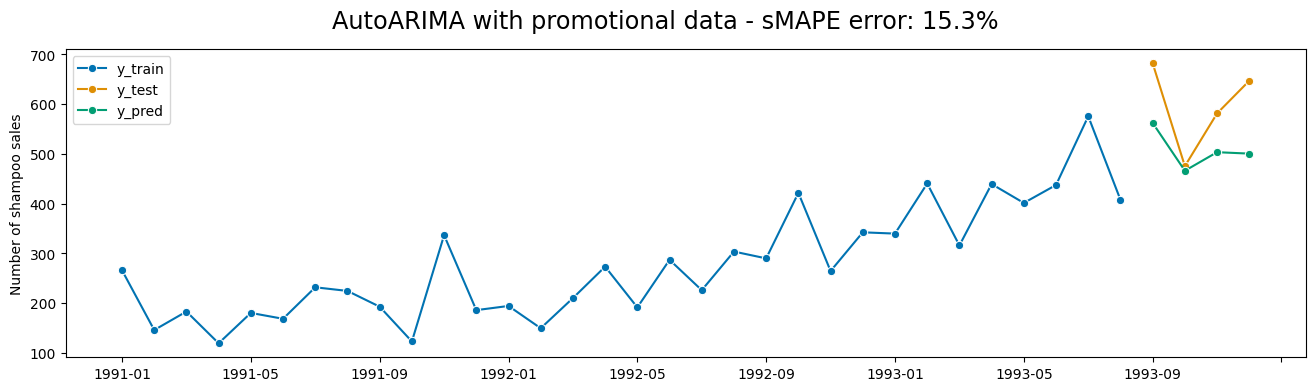

In [22]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

title = f"AutoARIMA with promotional data - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

Note: as we created the promotions from the sales data, the performance upflift is over-optimistic (data leakage).

But what if don't have future promotional data?

If we believe that we can forecast `X` (promotions) independently of `y` (sales) we can use these predictions of `X` to inform the predictions of `y`.

Here, we decide to use a different model for `X` than for `y`:
- y (sales): AutoARIMA
- X (promotion): Croston - due to intermittency


In [23]:
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.croston import Croston

forecaster_X = ForecastX(
    forecaster_y=AutoARIMA(suppress_warnings=True),
    forecaster_X=Croston(),
)
forecaster_X.fit(y=y, X=X_promo, fh=fh)

ForecastX(forecaster_X=Croston(),
          forecaster_y=AutoARIMA(suppress_warnings=True))

After fitting on both `X` and `y` we can creat predictions of `y` directly. Under the hood `sktime` is forecasting `X` with the `Croston()` model and using it in the prediction step of `y`.

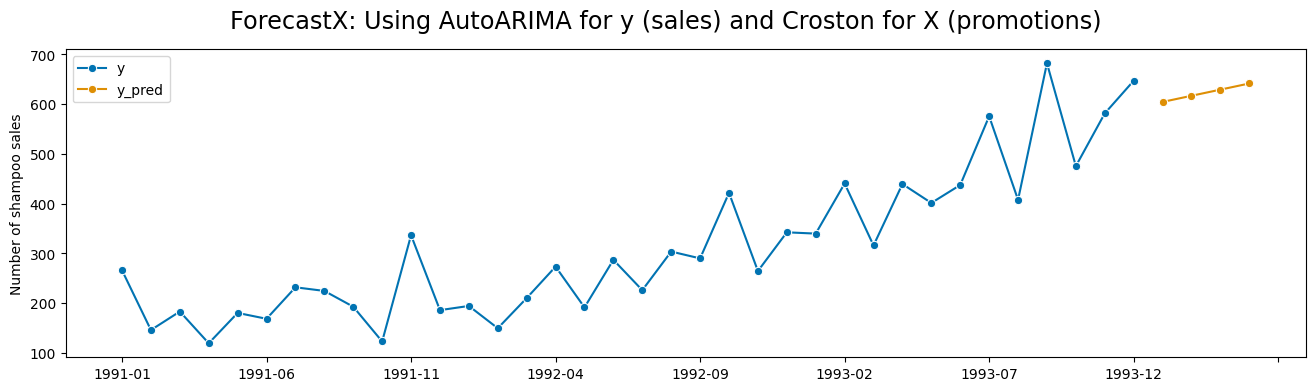

In [24]:
# Now in the `predict` step we don't need to pass X
y_pred = forecaster_X.predict(fh=fh)

title = f"ForecastX: Using AutoARIMA for y (sales) and Croston for X (promotions)"
fig, ax = plot_series(
    y, y_pred, labels=["y", "y_pred"], title=title
)

- Sometimes, the focus is not on a single univariate time series, but rather on forecasting a group of time series that represent different aspects of a single entity.
- Example: forecasting multiple macroeconomic indicators that collectively measure "the economy".

Let's explore how `sktime` enables multivariate forecasting for this use-case.

## Multivariate forecasting

dataset: multiple macroecon indicators, reported yearly ("Longley dataset")

In [25]:
from sktime.datasets import load_longley

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

y

GNPDEFL       GNP
Period                   
1947       83.0  234289.0
1948       88.5  259426.0
1949       88.2  258054.0
1950       89.5  284599.0
1951       96.2  328975.0
1952       98.1  346999.0
1953       99.0  365385.0
1954      100.0  363112.0
1955      101.2  397469.0
1956      104.6  419180.0
1957      108.4  442769.0
1958      110.8  444546.0
1959      112.6  482704.0
1960      114.2  502601.0
1961      115.7  518173.0
1962      116.9  554894.0

some forecasters, e.g., `VAR` are genuinely mutltivariate.

Let's predict:

In [26]:
from sktime.forecasting.var import VAR

forecaster = VAR()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()
y_pred

GNPDEFL            GNP
Period                           
1963    121.688295  578514.398653
1964    124.353664  601873.015890
1965    126.847886  625411.588754

multivariate/univariate is visible and searchable via tags,

e.g., `get_tags` to display properties of forecaster:

In [27]:
forecaster.get_tags()

{'python_dependencies_alias': {'scikit-learn': 'sklearn'},
 'scitype:y': 'multivariate',
 'ignores-exogeneous-X': True,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': False,
 'handles-missing-data': False,
 'y_inner_mtype': 'pd.DataFrame',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'python_version': None,
 'python_dependencies': 'statsmodels',
 'univariate-only': False}

But also all univariate forecasters can natively forecast multivariate data!

This is done by "broadcasting" across variables.

`ARIMA` is a purely univariate model:

In [28]:
from sktime.datasets import load_longley
from sktime.forecasting.arima import ARIMA

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

forecaster = ARIMA()
forecaster.fit(y, fh=[1, 2, 3])

forecaster.forecasters_

GNPDEFL      GNP
forecasters  ARIMA()  ARIMA()

`sktime` fits one single `ARIMA` model per variable.

Tags tell us that `ARIMA` is univariate, using `get_tags`:

In [29]:
forecaster.get_tags()

{'python_dependencies_alias': {'scikit-learn': 'sklearn'},
 'scitype:y': 'univariate',
 'ignores-exogeneous-X': False,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': True,
 'handles-missing-data': True,
 'y_inner_mtype': 'pd.Series',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'python_version': None,
 'python_dependencies': 'pmdarima'}

## Probabilistic forecasting

- Point predictions are often not enough!
- forecasts inherently contain some level of uncertainty
- important to estimate that uncertainty, "probabilistic predictions"
- example: uncertainty range from prediction intervals

`sktime` can make multiple types of probabilistic predictions

1st example: prediction intervals via `predict_interval`

In [30]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()

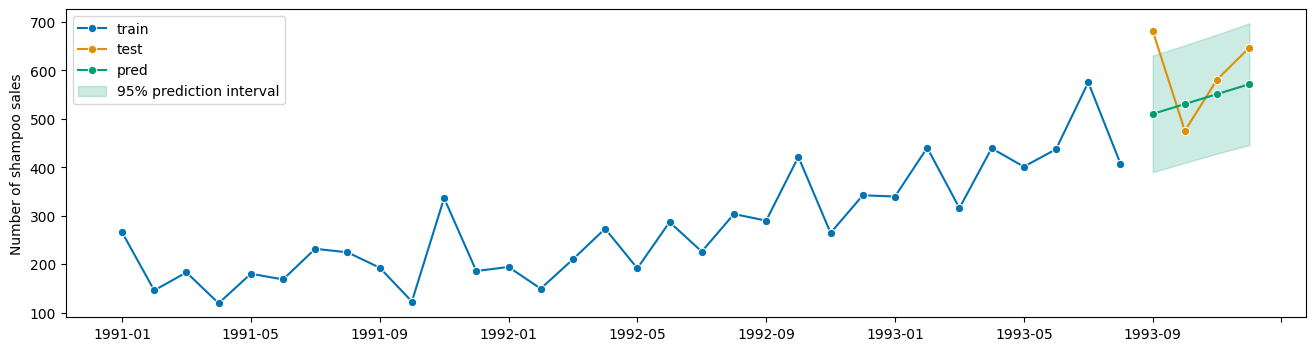

In [31]:
from sktime.forecasting.ets import AutoETS

# 1) Define the model
forecaster = AutoETS(auto=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4]
y_pred = forecaster.predict(fh)

# 4) Call a probabilistic method after or in place of step 3
y_pred_int = forecaster.predict_interval(coverage=0.95)

fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["train", "test", "pred"], pred_interval=y_pred_int
)

In [32]:
y_pred_int

Coverage            
               0.95            
              lower       upper
1993-09  389.650236  630.743131
1993-10  409.429859  651.972595
1993-11  428.319020  674.092522
1993-12  446.003062  697.417568

Methods available for all probabilistic forecasters:

- `predict_interval` produces interval forecasts.
  Argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts.
  Argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance forecasts. Same args as `predict`.
- `predict_proba` produces full distributional forecasts. Same args as `predict`.

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

`all_estimators` use to list all forecasters capable of proba predictions:

In [33]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster",
    filter_tags={"capability:pred_int": True},
    as_dataframe=True,
    suppress_import_stdout=False,
)

name  \
0                           ARIMA   
1                       AutoARIMA   
2                         AutoETS   
3                            BATS   
4               BaggingForecaster   
5        ColumnEnsembleForecaster   
6              ConformalIntervals   
7                   DynamicFactor   
8                FhPlexForecaster   
9                       ForecastX   
10        ForecastingGridSearchCV   
11            ForecastingPipeline   
12  ForecastingRandomizedSearchCV   
13       ForecastingSkoptSearchCV   
14                NaiveForecaster   
15                  NaiveVariance   
16                        Permute   
17                        Prophet   
18                        SARIMAX   
19              SquaringResiduals   
20         StatsForecastAutoARIMA   
21           StatsForecastAutoCES   
22           StatsForecastAutoETS   
23         StatsForecastAutoTheta   
24                          TBATS   
25                ThetaForecaster   
26    TransformedTargetForecaster   
27           UnobservedComponents   
28                            VAR   
29                           VECM   

                                               object  
0            <class 'sktime.forecasting.arima.ARIMA'>  
1        <class 'sktime.forecasting.arima.AutoARIMA'>  
2            <class 'sktime.forecasting.ets.AutoETS'>  
3              <class 'sktime.forecasting.bats.BATS'>  
4   <class 'sktime.forecasting.compose._bagging.Ba...  
5   <class 'sktime.forecasting.compose._column_ens...  
6   <class 'sktime.forecasting.conformal.Conformal...  
7   <class 'sktime.forecasting.dynamic_factor.Dyna...  
8   <class 'sktime.forecasting.compose._fhplex.FhP...  
9   <class 'sktime.forecasting.compose._pipeline.F...  
10  <class 'sktime.forecasting.model_selection._tu...  
11  <class 'sktime.forecasting.compose._pipeline.F...  
12  <class 'sktime.forecasting.model_selection._tu...  
13  <class 'sktime.forecasting.model_selection._tu...  
14  <class 'sktime.forecasting.naive.NaiveForecast...  
15   <class 'sktime.forecasting.naive.NaiveVariance'>  
16  <class 'sktime.forecasting.compose._pipeline.P...  
17     <class 'sktime.forecasting.fbprophet.Prophet'>  
18       <class 'sktime.forecasting.sarimax.SARIMAX'>  
19  <class 'sktime.forecasting.squaring_residuals....  
20  <class 'sktime.forecasting.statsforecast.Stats...  
21  <class 'sktime.forecasting.statsforecast.Stats...  
22  <class 'sktime.forecasting.statsforecast.Stats...  
23  <class 'sktime.forecasting.statsforecast.Stats...  
24           <class 'sktime.forecasting.tbats.TBATS'>  
25  <class 'sktime.forecasting.theta.ThetaForecast...  
26  <class 'sktime.forecasting.compose._pipeline.T...  
27  <class 'sktime.forecasting.structural.Unobserv...  
28               <class 'sktime.forecasting.var.VAR'>  
29             <class 'sktime.forecasting.vecm.VECM'>

Note:  estimators with`pred_int` tag always all probabilistic methods available - either all of them or none.

Presenting different proba methods and their outputs:

In [34]:
forecaster.predict_interval(coverage=0.95)

Coverage            
               0.95            
              lower       upper
1993-09  389.650236  630.743131
1993-10  409.429859  651.972595
1993-11  428.319020  674.092522
1993-12  446.003062  697.417568

In [35]:
forecaster.predict_quantiles(alpha=[0.275, 0.95])

Quantiles            
              0.275       0.950
1993-09  473.431794  611.362452
1993-10  493.715248  632.475368
1993-11  513.727123  654.335584
1993-12  533.371456  677.207167

In [36]:
forecaster.predict_var()

Number of shampoo sales
1993-09              3782.793645
1993-10              3828.427012
1993-11              3931.098665
1993-12              4113.623006

To predict full predictive distributions, `predict_proba` can be used. This returns a `BaseDistribution` child instance.

In [37]:
forecaster.predict_proba()

Normal(columns=Index(['Number of shampoo sales'], dtype='object'),
       index=PeriodIndex(['1993-09', '1993-10', '1993-11', '1993-12'], dtype='period[M]'),
       mu=         Number of shampoo sales
1993-09               510.196684
1993-10               530.701227
1993-11               551.205771
1993-12               571.710315,
       sigma=         Number of shampoo sales
1993-09                61.504420
1993-10                61.874284
1993-11                62.698474
1993-12                64.137532)

## Hierarchical forecasting

![](../images/hierarchy.png)

Consider hierarchical dataframe of historical monthly sales in different categories:

In [38]:
from hierarchical_demo_utils import load_product_hierarchy

y = load_product_hierarchy()

y

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

We can pick a specific date to clearly see the hierarchy.

In [39]:
# Multiindex slicing can become important when using hierarchical data!
y.loc[(slice(None), slice(None), "2000-01")]

Sales
Product line      Product group       
Food preparation  Hobs           245.0
                  Ovens          114.0
Food preservation Freezers       164.0
                  Fridges        136.0

Visualizing the different time series in the hierarchy:

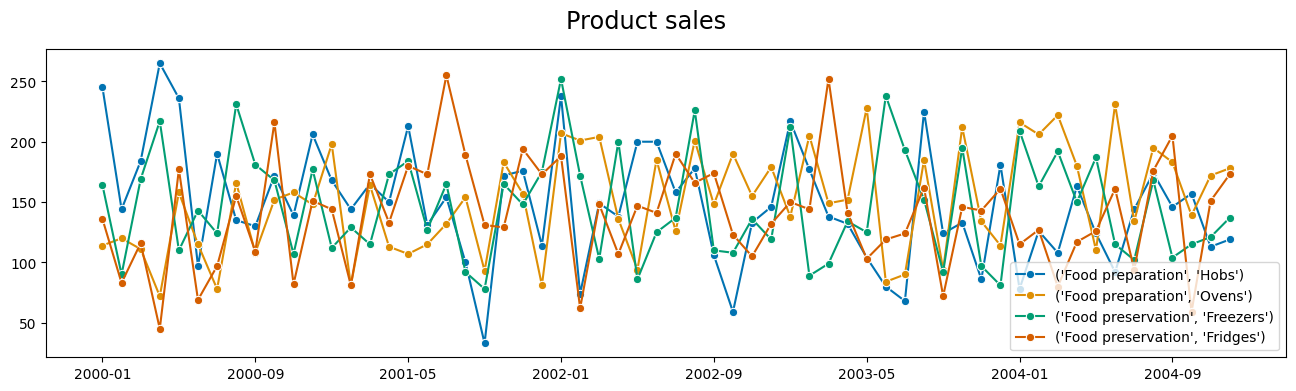

In [40]:
product_index = y.droplevel(-1).index.unique()
fig, ax = plot_series(*(y.loc[idx] for idx in product_index), labels=product_index, title="Product sales")

`sktime` broadcasts all non-hierarchical forecasters to hierarchical data:

In [41]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True)

y_pred = forecaster.fit_predict(y, fh=[1])
y_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460419
                  Ovens         2005-01  169.749332
Food preservation Freezers      2005-01  146.466778
                  Fridges       2005-01  139.583316

In [42]:
forecaster.forecasters_

forecasters
Food preparation  Hobs      AutoETS(auto=True)
                  Ovens     AutoETS(auto=True)
Food preservation Freezers  AutoETS(auto=True)
                  Fridges   AutoETS(auto=True)

For hierarchies, often want forecasts of aggregated levels.

Instead of manually summing up,

we can use `Aggregator` transformer in `sktime`:

In [43]:
from sktime.transformations.hierarchical.aggregate import Aggregator

y_hier = Aggregator().fit_transform(y)

y_hier.loc[(slice(None), slice(None), "2000-01")]

Sales
Product line      Product group       
Food preparation  Hobs           245.0
                  Ovens          114.0
                  __total        359.0
Food preservation Freezers       164.0
                  Fridges        136.0
                  __total        300.0
__total           __total        659.0

In [44]:
forecaster = AutoETS(auto=True, random_state=0)

y_hier_pred = forecaster.fit_predict(y_hier, fh=1)
y_hier_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460419
                  Ovens         2005-01  169.749332
                  __total       2005-01  298.431496
Food preservation Freezers      2005-01  146.466778
                  Fridges       2005-01  139.583316
                  __total       2005-01  286.049279
__total           __total       2005-01  584.481241

Compare top level and the sum of the bottom level forecasts...

... they do not add up!

In [45]:
584.481241 - (119.460419 + 169.749332 + 146.466778 + 139.583316)

9.221396000000027

Why? Independent instances of forecaster fitted per level,

no constraint to ensure the predictions add up.

In [46]:
forecaster.forecasters_

forecasters
Food preparation  Hobs      AutoETS(auto=True, random_state=0)
                  Ovens     AutoETS(auto=True, random_state=0)
                  __total   AutoETS(auto=True, random_state=0)
Food preservation Freezers  AutoETS(auto=True, random_state=0)
                  Fridges   AutoETS(auto=True, random_state=0)
                  __total   AutoETS(auto=True, random_state=0)
__total           __total   AutoETS(auto=True, random_state=0)

Use `ReconcilerForecaster` to enfore hierarchical reconciliation (= level forecasts add up)

`ReconcilerForecaster` takes a forecaster and adds reconciliation logic:

In [47]:
from sktime.forecasting.reconcile import ReconcilerForecaster

reconciler_forecaster = ReconcilerForecaster(
    forecaster=forecaster.clone(), method="bu"
)

y_hier_pred = reconciler_forecaster.fit_predict(y_hier, fh=1)
y_hier_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460419
                  Ovens         2005-01  169.749332
                  __total       2005-01  289.209751
Food preservation Freezers      2005-01  146.466778
                  Fridges       2005-01  139.583316
                  __total       2005-01  286.050094
__total           __total       2005-01  575.259845

Now top/bottom forecasts add up!

In [48]:
575.259845 - (119.460419 + 169.749332 + 146.466778 + 139.583316)

1.1368683772161603e-13

Available reconciliation in docstring or `METHOD_LIST`:

In [49]:
print("Valid reconciliation methods:")
for method in ReconcilerForecaster.METHOD_LIST:
    print(f"- {method}")

Valid reconciliation methods:
- mint_cov
- mint_shrink
- wls_var
- bu
- ols
- wls_str
- td_fcst


`HierarchyEnsembleForecaster` to customize forecasters at different hierarchy levels/nodes.

Forecasters built this way also aggregate the hierachical data for you under the hood.

In [50]:
from hierarchical_demo_utils import load_product_hierarchy

y = load_product_hierarchy()

In [51]:
from sktime.forecasting.compose import HierarchyEnsembleForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

forecasters = [
    ('Auto ARIMA', AutoARIMA(), 0),
    ('Auto ETS', AutoETS(auto=True), 1)
]

forecaster = HierarchyEnsembleForecaster(
                forecasters=forecasters,
                by='level', default = AutoETS(auto=True)
)

y_pred = forecaster.fit_predict(y, fh=[1])

y_pred

Sales
Product line      Product group Date               
Food preparation  Hobs          2005-01  119.460419
                  Ovens         2005-01  169.749332
                  __total       2005-01  298.431496
Food preservation Freezers      2005-01  146.466778
                  Fridges       2005-01  139.583316
                  __total       2005-01  286.049279
__total           __total       2005-01  585.824587

Up to now, all forecasts "per group"...

- Local: fit a model to each time series locally
- Global: fit a single model to all the series - below

### Global forecasting

Benefits of global forecasting:
- The model has access to more data to learn from, great when individual time series are short.
- Faster than local approach
- Empirically shown to outperform local models (e.g. M5 forecasting competition)

Note: global models assume the data generating procress for the group of time series is the same or at least similar.

In [52]:
from hierarchical_demo_utils import load_product_hierarchy
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_product_hierarchy()

y_train, y_test = temporal_train_test_split(y_hier, test_size=4)

y_test

Sales
Product line      Product group Date          
Food preparation  Hobs          2004-09  146.0
                                2004-10  157.0
                                2004-11  113.0
                                2004-12  119.0
                  Ovens         2004-09  183.0
                                2004-10  139.0
                                2004-11  172.0
                                2004-12  178.0
                  __total       2004-09  329.0
                                2004-10  296.0
                                2004-11  285.0
                                2004-12  297.0
Food preservation Freezers      2004-09  104.0
                                2004-10  115.0
                                2004-11  121.0
                                2004-12  137.0
                  Fridges       2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0
                  __total       2004-09  309.0
                                2004-10  174.0
                                2004-11  272.0
                                2004-12  310.0
__total           __total       2004-09  638.0
                                2004-10  470.0
                                2004-11  557.0
                                2004-12  607.0

Let's begin by using local forecasting with the gradient boosting regressor we used previously to forecast the hierarchical data.

In [53]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12, pooling="local")

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])

In [54]:
forecaster.forecasters_

forecasters
Food preparation  Hobs      DirectTabularRegressionForecaster(estimator=Hi...
                  Ovens     DirectTabularRegressionForecaster(estimator=Hi...
                  __total   DirectTabularRegressionForecaster(estimator=Hi...
Food preservation Freezers  DirectTabularRegressionForecaster(estimator=Hi...
                  Fridges   DirectTabularRegressionForecaster(estimator=Hi...
                  __total   DirectTabularRegressionForecaster(estimator=Hi...
__total           __total   DirectTabularRegressionForecaster(estimator=Hi...

We can adapt the error metrics to a hierarchical setting by using `multilevel` argument to obtain scores for each level.

In [55]:
hier_smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")
errors_local = hier_smape(y_test, y_pred)
errors_local

MeanAbsolutePercentageError
Food preparation  Hobs                         0.134782
                  Ovens                        0.175641
                  __total                      0.076075
Food preservation Freezers                     0.307519
                  Fridges                      0.482346
                  __total                      0.135877
__total           __total                      0.144789

Now with the same regressor, we do global forecasting by setting the `pooling` argument to `global`.

In [56]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12, pooling="global")

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])

Let's compare the scores for the `local` and `global` approach.

In [57]:
errors_global = hier_smape(y_test, y_pred)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")

Average sMAPE with local pooling: 20.8%
Average sMAPE with global pooling: 19.4%


Quick recap of what we have covered in this notebook:

- Univariate forecasting (stats and ML)
- Univariate with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

### Credits: notebook 3 - forecasting

notebook creation: marrov, fkiraly

partly based on:

* pydata 2022 Berlin notebooks (fkiraly, danbartl)
* sktime forecasting tutorial (fkiraly, mloning and others)

sktime forecasting module: [many contributors](https://www.sktime.net/en/latest/about/contributors.html)